# Fixing some interesting plots

Thought :

do : create synthetic datasets where 50% of the data is synthetic, and show how long (duration), amplitude (how heigh), or frequency (power) needs to be added for the abnormality to be detectable for a simple CNN.


1st: set duration 100 ms, amplitude 1 --> Add frequency 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600 , 1700, 1800, 1900, 2000

2nd: Set frequency = 400 Hz, duration = 100, and do: amplitude 0.5 - 10 with 0.5 step

3rd: Set frequency = 400 Hz, amplitude = 1 --> add duration 50 ms to 1 s by 50 ms 

In [1]:
import numpy as np
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join('../..'))
sys.path.insert(1, module_path + '/src')

import utility

import librosa
import sktime
from sktime.utils.data_io import load_from_tsfile_to_dataframe
from sklearn.model_selection import train_test_split

from math import ceil

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import librosa
from sklearn.metrics import f1_score, accuracy_score
from scipy.stats import skew 
import random

sys.path.insert(1, '/home/andrine/Desktop/tqwt_tools')
from tqwt_tools import DualQDecomposition
from scipy.signal import butter, lfilter
from scipy.fft import fft
from scipy.signal import stft
from scipy.stats import skew, kurtosis
from sklearn.metrics import classification_report

from sklearn import preprocessing
from keras.utils import np_utils
import keras
from keras.models import Model
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from keras.layers import Conv1D, ZeroPadding1D, MaxPooling1D, BatchNormalization, Activation, Dropout, Flatten, Dense

from sklearn.utils import shuffle
import librosa

from time import time
import sys
import os
import pickle


sys.path.insert(1, module_path + '/src/')

def znorm(timeseries):
    mean = np.mean(timeseries)
    sd = np.std(timeseries)
    return (timeseries - mean)/sd

target_rate = 44100
ds_target_rate = 5000

with open(module_path + '/data/tromsoSummary_compressed.pkl', 'rb') as f:
    data = pickle.load(f)
    
    
new_dataset = data.copy(deep = True)

new_dataset.loc[new_dataset['label'] == 'exp_wheeze' , 'label'] = 'wheeze'
new_dataset.loc[new_dataset['label'] == 'insp_wheeze' , 'label'] = 'wheeze'
new_dataset.loc[new_dataset['label'] == 'exp_crackle' , 'label'] = 'crackle'
new_dataset.loc[new_dataset['label'] == 'insp_crackle' , 'label'] = 'crackle'


id_unique = new_dataset['nr'].unique()

id_train , id_test = train_test_split(id_unique, test_size=0.2, random_state=42)
id_train , id_val = train_test_split(id_unique, test_size=0.25, random_state=42)

new_dataset.reset_index(drop = False)


def get_indices(id_list, data):
    indices = np.array([])
    for i in id_list:
        idx = np.where(data['nr'] == i)[0]
        #print(list(idx))
        #indices.append(list(idx))
        indices = np.append([list(idx)] , [indices])
        
    return indices

indices_train = get_indices(id_train, new_dataset).astype(int)
indices_test = get_indices(id_test, new_dataset).astype(int)
indices_val = get_indices(id_val, new_dataset).astype(int)

In [2]:
lowcut = 150
highcut = 2000
FRAME_RATE = 5000


def zero_pad(ts, fixed_len):
    df_new = np.zeros(fixed_len)
    len_ts = len(ts)
    pad = (fixed_len - len_ts)//2
    df_new[pad:pad + len_ts] = ts
    return df_new


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def bandpass_filter(buffer):
    return butter_bandpass_filter(buffer, lowcut, highcut, FRAME_RATE, order=12)

def split_on_scilence(audio, sr, split_rule = 2.5):
    subs = librosa.effects.split(audio, top_db = 39, frame_length = 60, hop_length = 25) # Split on scilence
    new_ls = []
    last_sub = subs[0]
    curr_sub = [] # Subs makes too many splits, need to add some winodows together

    rms_median = np.median(librosa.feature.rms(audio, frame_length = 40, hop_length = 20)) 


    for i in range(len(subs)):
        curr_sub.append(subs[i])

        if ( curr_sub[-1][1] - curr_sub[0][0]) >  split_rule*sr:  # Know that normal lung sounds usually lasts more than 2 seconds
            new_sub = audio[curr_sub[0][0] : curr_sub[-1][1]]
            rms_curr = np.mean(librosa.feature.rms(new_sub, frame_length = 50, hop_length = 25)) 
            
            if rms_curr > rms_median: # Make sure that window contains signal (lung sound has higher energy)
                new_ls.append(new_sub)

                curr_sub = []  
                
    return new_ls

def get_sub_audios_no_overlap(audio, frac):
    base = len(audio)//frac
    sub_audio = []
    for n in range(frac):
        #print(n*base)
        if (n+1)*base < len(audio):
            sub = audio[n*base : (n+1)*base]
            sub_audio.append(sub)
            #print(len(sub))
        else:
            sub = audio[n*base :]
            #print(len(sub))
            diff = len(sub) - len(sub_audio[-1])
            if diff != 0:
                print(diff)
                sub = audio[n*base - diff :]
            sub_audio.append(sub)
            #print(len(sub))
            #print(diff)
    

    return sub_audio

def get_sub_audios(audio, frac):
    base = len(audio)//frac
    half_base = base //2
    lengths = [(0, base)]

    while lengths[-1][1] < len(audio):
        lengths.append((lengths[-1][0] + base - half_base, lengths[-1][1] + base - half_base))

    sub_audio = []
    prev_len = len(audio[lengths[0][0]:lengths[0][1]])

    for l in lengths:
        sub = audio[l[0]:l[1]]
        if prev_len != len(sub):
            diff = prev_len - len(sub)
            sub = audio[l[0]- diff:l[1]]
            #print(diff)
        prev_len = len(sub)
        #print(len(sub))
        sub_audio.append(sub)
    return sub_audio

def get_data_array(data):
    error_in_data = {}
    count = 0
    
    X = []
    y = []
    for row in data.iterrows():
        '''print(X)
        print(len(X))
        if len(X) > 0:
            print(len(X[0]))'''
        audio_file = row[1]['id']
        label = row[1]['label']
        try:
            sr, audio = utility.read_wav_file(audio_file, target_rate)

        except EOFError as error:
            error_in_data[audio_file] = 'EOFError'
            continue

        try:
            audio = utility.denoise_audio(audio)
            audio, sr = utility.downsample(audio, sr, 5000), 5000

            audio = np.apply_along_axis(bandpass_filter, 0, audio).astype('float64')

            #sub_audio = get_sub_audios_no_overlap(audio, 3) # Set default 5 second window
            #sub_audio = get_sub_audios_no_overlap(audio, 5)
            
            #sub_audio = get_sub_audios(audio, 3)
            sub_audio = get_sub_audios(audio, 5)
            
            #sub_audio = split_on_scilence(audio, sr, split_rule = 2.5)
            #sub_audio = split_on_scilence(audio, sr, split_rule = 2)
            
            for sub in sub_audio:  
                #print(len(sub))
                if len(sub) > 50000:
                    #print('here')
                    continue
                sub = zero_pad(sub, 50000)
                
                
                X.append(sub)
                y.append(label)

        except ValueError as error:
            error_in_data[audio_file] = 'ValueError'
            continue
    return (np.array(X), pd.Series(y))


def get_model(input_shape, num_classes):
    model = Sequential()

    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=50))
    model.add(Conv1D(filters=50, kernel_size=6, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1500, activation='relu'))
    model.add(Dropout(0.25))

    #model.add(Dense(500, activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))
    optimizer = keras.optimizers.Nadam(lr=0.001)
    model.compile(loss="categorical_crossentropy", 
                  optimizer=optimizer, metrics=["accuracy"])
    return model

def get_CNN_ready_dataset(y, le):
    num_classes = len(le.classes_)
    y =  le.transform(y)
    y = np_utils.to_categorical(y, num_classes = num_classes)
    return y

from sklearn.exceptions import ConvergenceWarning
import warnings
warnings.filterwarnings('ignore', category=ConvergenceWarning)


In [3]:
indices = {
    'train' : indices_train,
    'test' : indices_test,
    'val' : indices_val
    
}

result_datasets = {
    'train' : ([], []),
    'test' : ([], []),
    'val' : ([], [])
    
}


for name, i in indices.items():
    result_datasets[name] = get_data_array(new_dataset.iloc[i])

In [4]:
X_train, y_train = result_datasets['train']
X_test, y_test = result_datasets['test']
X_val, y_val = result_datasets['val']

classes = y_train.unique()

# Preparing the data for the CNN
le = preprocessing.LabelEncoder()

le.fit(y_train)
num_classes = len(le.classes_)
X_train, y_train = shuffle(X_train, y_train, random_state = 42)

X_train = X_train.reshape(X_train.shape[0],X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1], 1)

y_train = get_CNN_ready_dataset(y_train, le)
y_test = get_CNN_ready_dataset(y_test, le)
y_val = get_CNN_ready_dataset(y_val, le)

# Training a simple CNN

batch_size = 100
epochs = 20
input_shape=(X_train.shape[1], 1)

model = get_model(input_shape, num_classes)

model.fit(X_train, y_train, epochs = epochs,
          batch_size = batch_size,
          verbose = 1,
         validation_data = (X_val, y_val))

Epoch 1/20
77/77 [==============================] - 127s 2s/step - loss: 1.0914 - accuracy: 0.3718 - val_loss: 1.0765 - val_accuracy: 0.4186
Epoch 2/20
77/77 [==============================] - 125s 2s/step - loss: 1.0798 - accuracy: 0.4206 - val_loss: 1.1441 - val_accuracy: 0.3492
Epoch 3/20
77/77 [==============================] - 122s 2s/step - loss: 1.0707 - accuracy: 0.4148 - val_loss: 1.0809 - val_accuracy: 0.4175
Epoch 4/20
77/77 [==============================] - 122s 2s/step - loss: 1.0515 - accuracy: 0.4499 - val_loss: 1.0791 - val_accuracy: 0.4066
Epoch 5/20
77/77 [==============================] - 121s 2s/step - loss: 1.0221 - accuracy: 0.4767 - val_loss: 1.0863 - val_accuracy: 0.4464
Epoch 6/20
77/77 [==============================] - 121s 2s/step - loss: 0.9859 - accuracy: 0.5094 - val_loss: 1.1425 - val_accuracy: 0.4355
Epoch 7/20
77/77 [==============================] - 123s 2s/step - loss: 0.9239 - accuracy: 0.5490 - val_loss: 1.1783 - val_accuracy: 0.4497
Epoch 8/20
77

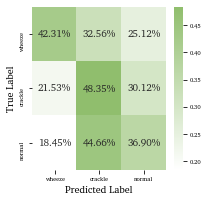

In [5]:
figure_path = module_path + '/figures/'

result = model.predict(X_test)
y_pred = np.argmax(result, axis = 1)
y_true = np.argmax(y_test, axis = 1)

f, ax = utility.plot_cm(y_true, y_pred, module_path = module_path, class_names = classes, color_index = 5)
plt.show()

f.savefig(figure_path + f'TSC/cm_uit_CNN_3s_overlap.pdf', bbox_inches='tight')